# Comparison of classifier vs. getSuspects

In [2]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

In [4]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_ptsd/core/disson_ptsd_core_with_actual_random_order_disson*.pkl"
    )
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_ptsd/core/disson_ptsd_core_with_actual_random_order_samples*.pkl"
    )
]

In [4]:
groups = ["qsampled", "actual"]

questions_asked = 20
_diss_dataset(diss[0], questions_asked, groups=groups)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,y
0,0.0,0.000000,0.000000,1.000000,0.647059,0.474657,0.112150,0.853659,0.324675,1.000000,...,1.000000,0.736842,0.000000,0.241379,1.000000,0.000000,0.938144,0.000000,0.938144,qsampled
1,0.0,0.725600,0.000000,1.000000,0.000000,0.476991,0.112150,0.958485,0.025974,0.000000,...,0.655914,0.941761,0.000000,0.241379,1.000000,0.978723,0.000000,0.000000,0.337017,qsampled
2,0.0,0.461411,0.000000,0.203704,0.000000,0.745332,0.887850,1.000000,0.000000,0.000000,...,0.537634,0.950943,0.000000,0.241379,0.000000,0.776596,0.618557,0.000000,1.000000,qsampled
3,1.0,0.391356,0.000000,1.000000,0.000000,0.959700,0.588785,0.853659,0.324675,0.974094,...,1.000000,0.000000,1.000000,0.000000,0.915254,0.000000,0.000000,1.000000,0.988950,qsampled
4,0.0,0.391356,0.082353,0.974400,1.000000,0.869197,0.112150,0.853659,0.389610,1.000000,...,0.537634,0.950943,0.857143,0.862069,0.915254,0.000000,0.000000,1.000000,0.983121,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.000000,0.235294,0.203704,0.250000,0.000000,0.000000,0.853659,0.025974,0.955571,...,0.000000,0.669811,0.571429,0.241379,0.915254,0.446809,0.618557,0.000000,0.000000,actual
300,0.9,0.716252,0.235294,1.000000,0.875000,0.606100,0.000000,0.000000,0.311688,0.955571,...,1.000000,0.200000,0.905405,1.000000,0.988889,0.776596,0.000000,0.829545,0.933702,actual
301,0.0,0.461411,0.082353,0.974400,0.647059,0.000000,0.112150,0.991697,0.311688,0.955540,...,0.537634,0.950943,0.857143,0.241379,0.000000,0.446809,0.000000,0.000000,0.842450,actual
302,0.0,0.000000,0.082353,0.974400,0.000000,0.548408,0.112150,0.853659,0.025974,0.951306,...,1.000000,0.669811,0.857143,0.241379,0.915254,0.000000,0.000000,0.000000,0.843162,actual


In [5]:
def _maling_prob(d, groups, questions_asked):
    data = _diss_dataset(d, questions_asked, groups=groups)
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop("y", axis="columns"), data["y"], test_size=0.33
    )

    fig, ax = plt.subplots()

    classifier = RandomForestClassifier(n_jobs=-1)

    classifier.fit(
        X_train.to_numpy(),
        y_train.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
    )

    r = RocCurveDisplay.from_estimator(
        classifier,
        X_test.to_numpy(),
        y_test.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
        pos_label=1,
        ax=ax,
        name=questions_asked,
    )

    plt.close()

    actual_data = _diss_dataset(d, questions_asked, groups=["actual"])

    pred = pd.Series(
        classifier.predict(actual_data.drop(["y"], axis="columns"))
    ).replace({0: "baseline", 1: groups[1]})

    pred_prob = pd.Series(
        classifier.predict_proba(actual_data.drop(["y"], axis="columns"))[:, 1],
        name=f"prob_{groups[1]}",
    )

    m2_prob = (
        pd.concat([actual_data.drop(["y"], axis="columns"), pred_prob], axis="columns")
        .set_index(pd.read_csv("data/ptsd/PTSD_cognet_test.csv")["record_id"])
        .reset_index()
        # .sort_values(by="prob_m2", ascending=False)
    )

    return m2_prob

# Runif case

In [48]:
groups = ["qsampled", "runif"]
questions_asked = 211
alpha = 0.01

mdfs = pd.concat([_maling_prob(d, groups, questions_asked) for d in diss])
mdfsavg = mdfs.groupby("record_id", as_index=False).mean()

suspects = pd.concat(
    [
        pd.read_csv(
            f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
            index_col=0,
        )
        for i in range(10)
    ]
)
suspects_mean = suspects.groupby(suspects.index).mean()

suspects_prob = mdfsavg.iloc[suspects.index, [0, -1]].join(suspects)
# display(suspects_prob)

print(f"mean {groups[1]} prob: ", mdfsavg[f"prob_{groups[1]}"].mean())
print(f"mean {groups[1]} prob (suspects): ", mdfsavg.iloc[suspects.index, -1].mean())

susp_diss = pd.concat(
    [
        _maling_prob(diss[i], groups, questions_asked)
        .join(
            pd.read_csv(
                f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
                index_col=0,
            )
        )
        .assign(alpha=alpha)
        for i in range(len(diss))
        for alpha in [0.01]
    ]
)

mean runif prob:  0.23168749999999996
mean runif prob (suspects):  0.6970263157894736


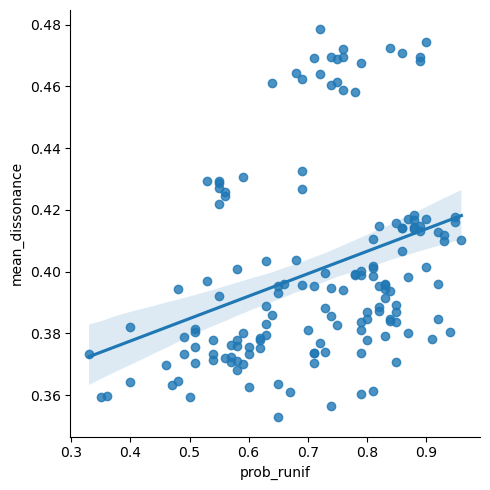

In [49]:
sns.lmplot(
    susp_diss,
    x="prob_runif",
    y="mean_dissonance",
)

In [50]:
susp_diss.query("mean_dissonance.notna()")

,record_id,0,1,2,3,4,5,6,7,8,...,626,627,628,629,630,631,632,prob_runif,mean_dissonance,alpha
9,CAT1010,0.253044,0.417490,0.192165,0.307181,0.854707,0.585333,0.228021,0.718373,0.025126,...,0.892031,0.978703,0.941106,0.980451,0.984558,0.940407,0.444563,0.51,0.380361,0.01
60,CAT1061,0.000000,0.936884,0.188545,0.199626,0.887528,0.673175,0.819055,0.700147,0.476371,...,0.987577,0.613485,0.919558,0.978455,0.984516,0.930622,0.444068,0.55,0.429343,0.01
63,CAT1064,0.000000,0.849270,0.263930,0.000000,0.000000,0.595251,0.818115,0.722459,0.000000,...,0.987592,0.978564,0.995565,0.980154,0.980835,0.930635,0.444068,0.81,0.401782,0.01
86,CAT1087,0.000000,0.000000,0.273668,0.000000,0.853183,0.595364,0.235537,0.684386,0.468832,...,0.594997,0.982454,0.981164,0.978683,0.980421,0.930622,0.444415,0.54,0.377962,0.01
98,CAT1099,0.439223,0.000000,0.000000,0.000000,0.000000,0.000000,0.545466,0.186764,0.468832,...,0.892355,0.912877,0.965859,0.984068,0.980732,0.940969,0.268641,0.88,0.414350,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,CAT1226,0.000000,0.000000,0.606805,0.167394,0.000000,0.637458,0.097234,0.728634,0.025092,...,0.978176,0.991348,0.984577,0.865217,0.948987,0.945529,0.449503,0.36,0.359670,0.01
252,CAT1253,0.130507,0.874552,0.256546,0.167266,0.777068,0.637458,0.443384,0.136339,0.707110,...,0.867852,0.982878,0.896263,0.977565,0.949757,0.827031,0.444627,0.82,0.388622,0.01
261,CAT1262,0.000000,0.000000,0.000000,0.000000,0.000000,0.682348,0.777477,0.811917,0.563182,...,0.978220,0.983475,1.000000,0.976471,0.981180,0.838411,0.444339,0.68,0.464279,0.01
282,CAT1283,0.109569,0.277486,0.000000,0.000000,0.000000,0.637125,0.776613,0.727118,0.457222,...,0.978371,0.983043,1.000000,0.878977,0.949807,0.946420,0.436033,0.74,0.469505,0.01


# Expert malingering case

In [51]:
groups = ["qsampled", "m2"]
questions_asked = 211
alpha = 0.01

mdfs = pd.concat([_maling_prob(d, groups, questions_asked) for d in diss])
mdfsavg = mdfs.groupby("record_id", as_index=False).mean()

suspects = pd.concat(
    [
        pd.read_csv(
            f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
            index_col=0,
        )
        for i in range(10)
    ]
)
suspects_mean = suspects.groupby(suspects.index).mean()

suspects_prob = mdfsavg.iloc[suspects.index, [0, -1]].join(suspects)
# display(suspects_prob)

print(f"mean {groups[1]} prob: ", mdfsavg[f"prob_{groups[1]}"].mean())
print(f"mean {groups[1]} prob (suspects): ", mdfsavg.iloc[suspects.index, -1].mean())

susp_diss = pd.concat(
    [
        _maling_prob(diss[i], groups, questions_asked)
        .join(
            pd.read_csv(
                f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
                index_col=0,
            )
        )
        .assign(alpha=alpha)
        for i in range(len(diss))
        for alpha in [0.01]
    ]
)

mean m2 prob:  0.5281973684210527
mean m2 prob (suspects):  0.07790131578947368


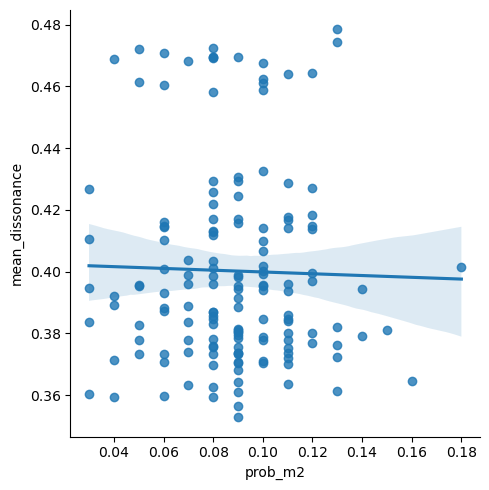

In [53]:
sns.lmplot(
    susp_diss,
    x="prob_m2",
    y="mean_dissonance",
)